# Decode stimuli/block/licks from neural activity - DR

In [17]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import glob
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [5]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
]

mouseIDs = ['626791','626791','626791']
exp_nums = [1,2,3]

## Load a single session

In [8]:
sel_session=0
session=Session(path=main_path[sel_session]) 

In [9]:
# trials table
session.trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,433,87.284220,0.020720,0.5
1,1,674,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,803,93.456000,0.020720,0.5
2,2,1044,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1197,100.030075,0.022585,0.5
3,3,1438,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1600,106.752255,0.022585,0.5
4,4,1841,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1993,113.307625,0.022345,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,213238,sound2,sound1,True,False,0.5,0.0,False,False,...,True,False,False,False,False,False,213351,3639.015417,0.105667,0.5
475,475,213592,vis2,sound1,False,False,0.0,0.5,False,True,...,False,False,False,False,False,False,214200,3653.094225,0.022725,0.5
476,476,214441,sound1,sound1,True,True,0.5,0.0,False,False,...,False,False,False,False,False,False,214582,3659.534919,0.091479,0.5
477,477,214823,vis1,sound1,False,False,0.0,0.5,True,False,...,False,False,False,False,False,False,215388,3672.910360,0.022480,0.5


In [10]:
# add area labels if they exist
tissuecyte_path = r"\\allen\programs\mindscope\workgroups\np-behavior\tissuecyte"

session.units['area']=''
session.good_units['area']=''

if os.path.isdir(os.path.join(tissuecyte_path,mouseIDs[sel_session])):
    for probe in session.units['probe'].unique():
        if type(probe)==str:
            
            channels_table_path=glob.glob(
                os.path.join(tissuecyte_path,mouseIDs[sel_session],
                             '*'+probe+str(exp_nums[sel_session])+'_channels*'))
            if len(channels_table_path)==1:
                channels_table=pd.read_csv(channels_table_path[0])
            else:
                continue

            for ic,chan in channels_table.iterrows():
                chan_units = session.units.query('peak_channel == @chan.channel and \
                                                    probe == @probe').index
                if len(chan_units)>0:
                    if 'region' in chan:
                        assign_area = chan['region']
                    elif 'channel_areas' in chan:
                        assign_area = chan['channel_areas']

                    session.units['area'][chan_units] = assign_area
#                 print(chan_units)
#                 print(chan.channel)
#                 print(chan.channel_areas)


                chan_units = session.good_units.query('peak_channel == @chan.channel and \
                                                        probe == @probe').index
                if len(chan_units)>0:
                    if 'region' in chan:
                        assign_area = chan['region']
                    elif 'channel_areas' in chan:
                        assign_area = chan['channel_areas']
                    session.good_units['area'][chan_units] = assign_area


    session.good_units['area'][session.good_units['area'].isna()]='N/A'
    session.units['area'][session.units['area'].isna()]='N/A'

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.good_units['area'][chan_units] = assign_area
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_36076\1364337257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [11]:
# units table
session.good_units

,quality,cluster_id,probe,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,...,duration,halfwidth,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below,area
id,,,,,,,,,,,,,,,,,,,,,
2208151110004,good,4,A,19.871350,0.99,0.049522,0.022552,37.552305,0.128942,3.578176,...,0.467002,0.288442,0.556657,0.205305,-0.036398,72.207525,90.0,0.732552,NaN,VPM
2208151110002,good,2,A,4.481252,0.99,0.053188,0.028146,9.644711,2.208028,2.251783,...,0.453266,0.274707,0.607209,0.340725,-0.078481,107.780595,90.0,1.854271,NaN,VPM
2208151110006,good,6,A,12.692753,0.99,0.025500,0.037872,28.045546,0.376475,3.028024,...,0.439531,0.260972,0.561105,0.443039,-0.088636,141.483615,90.0,0.309045,NaN,VPM
2208151110012,good,12,A,18.970627,0.99,0.050457,0.032922,35.733932,0.134704,3.578971,...,0.370854,0.206030,0.742666,0.351710,-0.076446,95.180865,100.0,1.299289,-0.343384,VPM
2208151110014,good,14,A,9.237390,0.99,0.061624,0.025082,64.905296,0.130465,4.600663,...,0.412060,0.219765,0.735893,0.427707,-0.077755,125.922615,50.0,-0.343384,-0.343384,VPM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208151160439,good,439,F,11.047175,0.99,0.035681,0.012408,32.232810,0.286242,2.405390,...,0.274707,0.123618,0.511174,0.642975,-0.101884,144.925365,50.0,-0.343384,-0.343384,MOs2/3
2208151160442,good,442,F,2.272084,0.99,0.334226,0.010561,49.006266,0.005357,2.917428,...,0.384590,0.137353,0.404541,0.564044,-0.035261,135.811065,40.0,1.373534,-1.030151,MOs2/3
2208151160443,good,443,F,36.168340,0.99,0.002827,0.001311,141.786831,0.001938,6.269814,...,0.755444,0.274707,0.396488,0.279083,-0.028106,166.776285,60.0,2.060302,0.068677,MOs2/3


In [12]:
session.good_units['area'].value_counts()

CP          83
LGd-co      52
CA1         47
PO          45
LP          32
VISpm5      32
VPM         30
LD          28
AUDpo5      27
AUDp6a      25
LGd-sh      23
TEa5        20
BST         18
TEa4        17
MOs6a       16
MOs2/3      15
PS          14
DG-sg       13
VISpm6a     12
MOs5        11
ZI          10
AUDp6b       8
DG-po        8
AUDpo6a      8
CA3          7
LPO          7
DG-mo        6
LGv          5
STR          5
IGL          5
VISpm4       4
RSPd6a       4
N/A          4
RSPd5        4
TH           2
VISli2/3     2
TEa2/3       2
IntG         1
VISpm6b      1
Name: area, dtype: int64

In [13]:
# spike times from one unit
session.spike_times[session.units.index[0]]

array([  11.01369951,   11.65646469,   11.81169766, ..., 4569.39638463,
       4569.65641736, 4571.51424639])

In [14]:
# information about each frame
session.frames

,Unnamed: 0,vsyncTimes,frameDelay,runningSpeed
0,0,80.04110,0.020720,0.000000
1,1,80.05762,0.020720,19.208968
2,2,80.07423,0.022585,18.777305
3,3,80.09092,0.022585,18.777305
4,4,80.10810,0.022345,19.640630
...,...,...,...,...
216905,216905,3698.19226,0.022550,5.611609
216906,216906,3698.20886,0.022625,7.122426
216907,216907,3698.22558,0.022625,7.985751
216908,216908,3698.24227,0.022405,9.064906


In [15]:
# loop through sessions and make unit xarrays
time_before_flash = 1.5
trial_duration = 3
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### decode by area

In [202]:
# session.good_units['area'].value_counts()

In [18]:
#shorten the area names to better lump together units
#get rig of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [19]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>25].index

Index(['CP', 'LGd', 'VISpm', 'CA1', 'PO', 'MOs', 'TEa', 'AUDpo', 'AUDp', 'LP',
       'VPM', 'LD', 'DG'],
      dtype='object')

In [20]:
session.trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,433,87.284220,0.020720,0.5
1,1,674,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,803,93.456000,0.020720,0.5
2,2,1044,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1197,100.030075,0.022585,0.5
3,3,1438,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1600,106.752255,0.022585,0.5
4,4,1841,vis1,vis1,True,True,0.0,0.5,True,False,...,False,False,False,False,False,False,1993,113.307625,0.022345,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,213238,sound2,sound1,True,False,0.5,0.0,False,False,...,True,False,False,False,False,False,213351,3639.015417,0.105667,0.5
475,475,213592,vis2,sound1,False,False,0.0,0.5,False,True,...,False,False,False,False,False,False,214200,3653.094225,0.022725,0.5
476,476,214441,sound1,sound1,True,True,0.5,0.0,False,False,...,False,False,False,False,False,False,214582,3659.534919,0.091479,0.5
477,477,214823,vis1,sound1,False,False,0.0,0.5,True,False,...,False,False,False,False,False,False,215388,3672.910360,0.022480,0.5


In [138]:
# # grab data: make these [trials,neurons] matrices based on different time bins:
# trial_sel=session.trials.query('(trialStimID == "sound1" and trial_response == True)').index

# area_sel = area_counts[area_counts>25].index

# # grab the stimulus ids
# stim_ids = session.trials['trialStimID'][trial_sel].values
# # or, use block IDs
# block_ids = session.trials['trialstimRewarded'][trial_sel].values
# #or, use whether mouse responded
# trial_response = session.trials['trial_response'][trial_sel].values

# # choose what variable to predict
# pred_var = block_ids

# ### make sure equal # of trials per condition!
# conds = np.unique(pred_var)
# cond_count = np.zeros(len(conds))
# for ic,cc in enumerate(conds):
#     cond_count[ic]=np.sum(pred_var==cc)
    
# min_n_trials=np.min(cond_count).astype(int)

# subset_ind=[]

# for cc in conds:
#     cond_inds=np.where(pred_var==cc)[0]
#     subset_ind.append(np.random.choice(cond_inds,min_n_trials,replace=False))
    
# subset_ind=np.sort(np.hstack(subset_ind))

In [140]:
# subset_ind

In [175]:
#try more timepoints & split by areas

svc_results={}
binsize=0.05

# grab data: make these [trials,neurons] matrices based on different time bins:
trial_sel=session.trials.query('(trialStimID == "vis1" or trialStimID == "sound1") and \
                                trial_response == False').index

# area_sel = area_counts[area_counts>25].index
area_sel = ['all']

# grab the stimulus ids
stim_ids = session.trials['trialStimID'][trial_sel].values
# or, use block IDs
block_ids = session.trials['trialstimRewarded'][trial_sel].values
#or, use whether mouse responded
trial_response = session.trials['trial_response'][trial_sel].values

#choose what variable to predict
pred_var = block_ids

### make sure equal # of trials per condition!
conds = np.unique(pred_var)
cond_count = np.zeros(len(conds))
for ic,cc in enumerate(conds):
    cond_count[ic]=np.sum(pred_var==cc)
min_n_trials=np.min(cond_count).astype(int)
subset_ind=[]
for cc in conds:
    cond_inds=np.where(pred_var==cc)[0]
    subset_ind.append(np.random.choice(cond_inds,min_n_trials,replace=False))   
subset_ind=np.sort(np.hstack(subset_ind))
trial_sel=trial_sel[subset_ind]
pred_var=pred_var[subset_ind]


time_bins=np.arange(-0.2,0.6,binsize)

for aa in area_sel:
    if aa=='all':
        unit_sel = session.good_units.index.values
    else:
        unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
    svc_results[aa]={}
    for tt,t_start in enumerate(time_bins[:-1]):
        
        sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                        trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
#     for tt,t_end in enumerate(time_bins[1:]):
        
#         sel_data = session.trial_da.sel(time=slice(time_bins[0],t_end),
#                                         trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
        X = sel_data.T
        y = pred_var

        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

        clf = svm.LinearSVC()
        clf.fit(xtrain, ytrain)

        ypred = clf.predict(xtest)

        cr_dict=classification_report(ytest, ypred, output_dict=True)
        cr_df=pd.DataFrame.from_dict(cr_dict)

        svc_results[aa][tt]=cr_df
        
        

In [170]:
# svc_results

In [176]:
# make into more plottable format

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

for aa in areas:
    plot_results[aa]={}
#     plot_results[tt]['modality']=modality
    plot_results[aa]['vis1']=[]
    plot_results[aa]['vis2']=[]
    plot_results[aa]['aud1']=[]
    plot_results[aa]['aud2']=[]
    
    plot_results[aa]['True']=[]
    plot_results[aa]['False']=[]
#     for tt,tp in enumerate(timepoints):
#         plot_results[aa][tt]=[]
        

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: #svc_results[ss]['results'].keys():
    if aa in svc_results.keys():
        for tt,tp in enumerate(timepoints):
            
            if 'vis1' in svc_results[aa][tt].keys():
                vis1_perf=np.mean(svc_results[aa][tt]['vis1'][['precision','recall']].values)
                plot_results[aa]['vis1'].append(vis1_perf)
                
            if 'vis2' in svc_results[aa][tt].keys():
                vis2_perf=np.mean(svc_results[aa][tt]['vis2'][['precision','recall']].values)
                plot_results[aa]['vis2'].append(vis2_perf)
                
            if 'sound1' in svc_results[aa][tt].keys():
                aud1_perf=np.mean(svc_results[aa][tt]['sound1'][['precision','recall']].values)
                plot_results[aa]['aud1'].append(aud1_perf)
                
            if 'sound2' in svc_results[aa][tt].keys():
                aud2_perf=np.mean(svc_results[aa][tt]['sound2'][['precision','recall']].values)
                plot_results[aa]['aud2'].append(aud2_perf)
                
            if 'True' in svc_results[aa][tt].keys():
                aud1_perf=np.mean(svc_results[aa][tt]['True'][['precision','recall']].values)
                plot_results[aa]['True'].append(aud1_perf)
                
            if 'False' in svc_results[aa][tt].keys():
                aud2_perf=np.mean(svc_results[aa][tt]['False'][['precision','recall']].values)
                plot_results[aa]['False'].append(aud2_perf)

#     plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [95]:
# plot_results

<IPython.core.display.Javascript object>


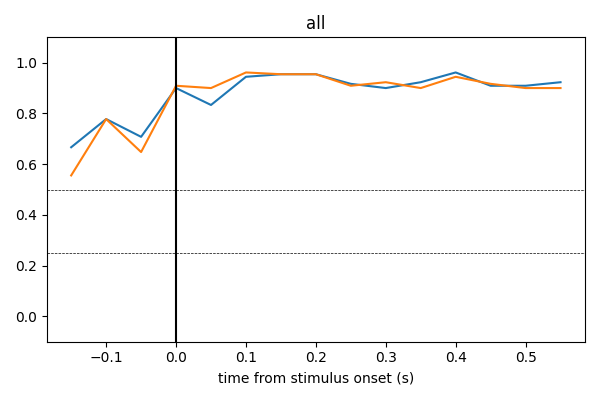

In [177]:
fig,ax=plt.subplots(len(plot_results.keys()),1,figsize=(6,4))

if type(ax)!=np.ndarray:
    ax=[ax]

for aa,area in enumerate(plot_results.keys()):
    ax[aa].plot(timepoints,plot_results[area]['vis1'])
    ax[aa].plot(timepoints,plot_results[area]['aud1'])
    ax[aa].set_ylim([-0.1,1.1])
    ax[aa].axvline(0,color='k')
    ax[aa].axhline(0.25,color='k',linewidth=0.5,linestyle='--')
    ax[aa].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[aa].set_title(area)
    if aa<len(plot_results.keys())-1:
        ax[aa].set_xticklabels('')

ax[aa].set_xlabel('time from stimulus onset (s)')
fig.tight_layout()